In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
import seaborn as sns
import ast
import folium
import os
from tqdm import tqdm

In [2]:
df_cpt = pd.read_csv('../Data/CPT.csv', index_col=0)

In [3]:
df_tcmt = pd.read_csv('../Data/Tacheometry.csv', index_col=0)

In [4]:
df_tcmt['points'] = gpd.points_from_xy(df_tcmt['X_coordinate'], df_tcmt['Y_coordinate'])
df_objects = df_tcmt.groupby('objectid').agg(
            geometry = pd.NamedAgg(column='points', aggfunc= lambda x: sg.LineString(x.values)))
df_objects = df_objects.reset_index()
gdf_objects = gpd.GeoDataFrame(df_objects, crs="EPSG:28992", geometry=df_objects['geometry'])

gdf_buffer = gdf_objects.copy()
gdf_buffer['geometry'] = gdf_buffer['geometry'].buffer(2)
gdf_buffer.crs = "EPSG:28992"
gdf_buffer = gdf_buffer.to_crs("EPSG: 4326")

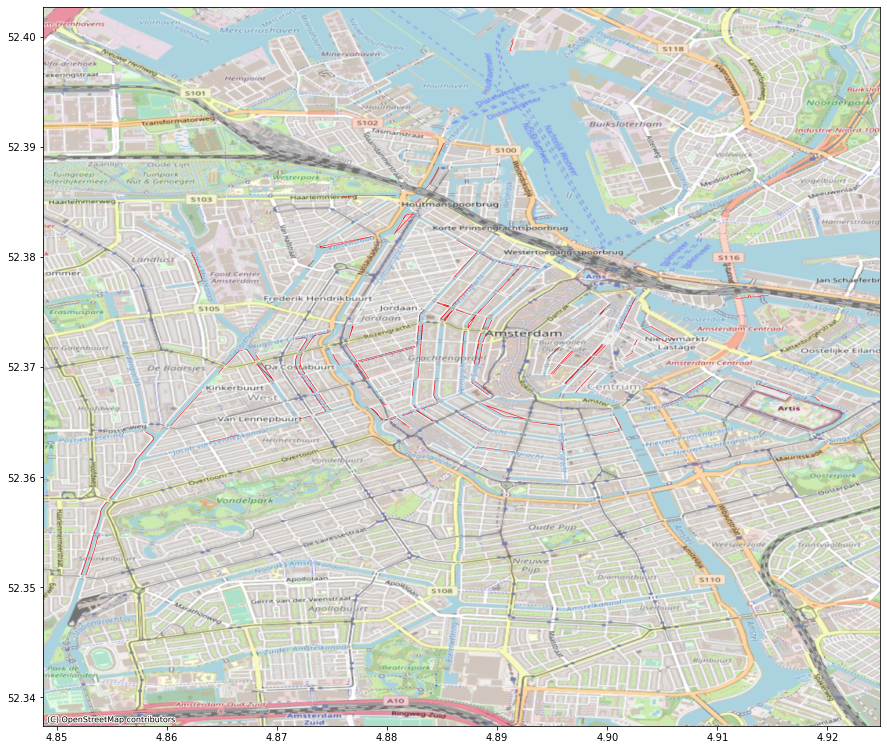

In [5]:
fig, ax = plt.subplots(figsize=(15,15))

# plot datapoints
gdf_buffer.plot(ax=ax, color='r')

# add background of city of Amsterdam
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_buffer.crs)

# ax.axis('off')
plt.show()

In [6]:
# create geo dataframe based on X and Y coordinates
gdf_cpt = gpd.GeoDataFrame(df_cpt, geometry=gpd.points_from_xy(df_cpt['easting'], \
                                                               df_cpt['northing']))

# add the correct coordinate system (Dutch RD)
gdf_cpt.crs = "EPSG:28992"

# project onto gps coordinate system for visualisation purposes
gdf_cpt = gdf_cpt.to_crs("EPSG: 4326")

In [7]:
gdf_joined = gpd.sjoin(left_df=gdf_buffer, right_df=gdf_cpt, how='inner')

In [8]:
# create depth intervals of every 0.5 meter
cut = pd.cut(gdf_joined['depth'], bins=[i*0.5 for i in range(0, 150)])

# calculate mean of frictionRatio per depth interval per object
mean = gdf_joined.groupby(['objectid', cut])['frictionRatio'].mean()
df_per_depth = pd.DataFrame(mean).reset_index(level=1)
df_per_depth.index.name= None

# create columns of values per depth interval for frictionRatio
df_per_depth = df_per_depth.pivot_table(values='frictionRatio', index=df_per_depth.index, columns='depth', dropna=False)
df_per_depth = df_per_depth.dropna(axis=1, how='all')
df_per_depth.columns = [f'FrictionRatioAt{i*0.5 + 0.25}' for i in range(len(cut.unique())-1)]

# calculate mean of coneResistance per depth interval per object
mean = gdf_joined.groupby(['objectid', cut])['coneResistance'].mean()
df_per_depth2 = pd.DataFrame(mean).reset_index(level=1)
df_per_depth2.index.name= None

# create columns of values per depth interval for coneResistance
df_per_depth2 = df_per_depth2.pivot_table(values='coneResistance', index=df_per_depth2.index, columns='depth', dropna=False)
df_per_depth2 = df_per_depth2.dropna(axis=1, how='all')
df_per_depth2.columns = [f'coneResistanceAt{i*0.5 + 0.25}' for i in range(len(cut.unique())-1)]

# get maximum value per objectid of elapsed time (seems cumulative, so is now total)
df_time = gdf_joined.groupby('objectid')['elapsedTime'].max()

# combine into one dataframe
gdf_joined = gdf_joined.merge(df_per_depth, left_on='objectid', right_on=df_per_depth.index)
gdf_joined = gdf_joined.merge(df_per_depth2, left_on='objectid', right_on=df_per_depth2.index)
gdf_joined = gdf_joined.merge(df_time, left_on='objectid', right_on=df_time.index)

# remove redundant columns, remove duplicate rows, to yield one row per object
gdf_joined = gdf_joined.drop(['index_right', 'coneResistance', 'localFriction', 'depth', 'elapsedTime_x', 'penetrationLength', 'frictionRatio', 'inclinationResultant', 'inclinationEW', 'inclinationNS', 'easting', 'northing', 'groundlevel'], axis=1).drop_duplicates()

In [9]:
# delete rows with only NaN values
all_nan = gdf_joined.iloc[:,2:-1].isna().all(axis=1)
gdf_joined = gdf_joined.drop(all_nan[all_nan == True].index)

In [10]:
# fillna with previous valid value, then fillna with next valid value
frictionratios = [col for col in gdf_joined.columns if 'FrictionRatio' in col]
gdf_joined[frictionratios] = gdf_joined[frictionratios].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# fillna with previous valid value, then fillna with next valid value
coneresistances = [col for col in gdf_joined.columns if 'coneResistance' in col]
gdf_joined[coneresistances] = gdf_joined[coneresistances].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# fill nans for elapsed time with median
gdf_joined['elapsedTime_y'] = gdf_joined['elapsedTime_y'].fillna(value=gdf_joined['elapsedTime_y'].median())

gdf_joined

,objectid,geometry,FrictionRatioAt0.25,FrictionRatioAt0.75,FrictionRatioAt1.25,FrictionRatioAt1.75,FrictionRatioAt2.25,FrictionRatioAt2.75,FrictionRatioAt3.25,FrictionRatioAt3.75,...,coneResistanceAt38.25,coneResistanceAt38.75,coneResistanceAt39.25,coneResistanceAt39.75,coneResistanceAt40.25,coneResistanceAt40.75,coneResistanceAt41.25,coneResistanceAt41.75,coneResistanceAt42.25,elapsedTime_y
0,BDG0101,"POLYGON ((4.86708 52.37162, 4.86719 52.37163, ...",12.488889,12.488889,5.072000,5.332000,6.856000,6.136000,6.028000,5.564000,...,3.022000,3.022000,3.022000,3.022000,3.022000,3.022000,3.022000,3.022000,3.022000,2688.0
1480,BDG0202,"POLYGON ((4.86856 52.37038, 4.86856 52.37038, ...",11.388889,11.388889,5.096000,5.340000,6.840000,6.128000,6.024000,5.528000,...,3.103000,3.103000,3.103000,3.103000,3.103000,3.103000,3.103000,3.103000,3.103000,2687.0
7477,DCG0101,"POLYGON ((4.87204 52.37151, 4.87204 52.37151, ...",6.200000,6.200000,6.200000,3.808000,2.788000,1.792000,2.008000,6.824000,...,2.126565,2.126565,2.126565,2.126565,2.126565,2.126565,2.126565,2.126565,2.126565,1896.0
9059,DCG0202,"POLYGON ((4.87225 52.37122, 4.87225 52.37122, ...",2.900000,2.900000,2.900000,2.900000,1.856000,2.152000,3.416000,1.728000,...,2.393632,2.393632,2.393632,2.393632,2.393632,2.393632,2.393632,2.393632,2.393632,2125.0
10551,DCG0302,"POLYGON ((4.87263 52.36923, 4.87263 52.36923, ...",1.650000,1.650000,1.650000,1.650000,4.168000,3.710000,9.114000,9.478000,...,2.450500,2.459040,2.491640,2.614000,3.513280,5.723800,6.483038,3.783560,4.303750,2342.0
14053,GRW0101,"POLYGON ((4.89766 52.36837, 4.89773 52.36844, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.396000,...,1.950674,1.950674,1.950674,1.950674,1.950674,1.950674,1.950674,1.950674,1.950674,2682.0
19543,HEG0302,"POLYGON ((4.88734 52.37355, 4.88734 52.37355, ...",1.993103,1.993103,1.993103,1.993103,3.362667,3.145333,4.952632,6.492000,...,2.863417,2.863417,2.863417,2.863417,2.863417,2.863417,2.863417,2.863417,2.863417,4346.8
26461,HEG0401,"POLYGON ((4.88689 52.37236, 4.88689 52.37237, ...",7.716667,7.716667,7.716667,7.716667,4.140000,6.024000,7.664000,8.140000,...,3.173467,3.173467,3.173467,3.173467,3.173467,3.173467,3.173467,3.173467,3.173467,2881.0
27892,HEG0802,"POLYGON ((4.88862 52.36669, 4.88862 52.36669, ...",3.700000,3.700000,3.700000,3.700000,2.564000,6.148000,8.656000,6.596000,...,2.075833,2.075833,2.075833,2.075833,2.075833,2.075833,2.075833,2.075833,2.075833,1938.0
29417,HEG0901,"POLYGON ((4.89568 52.36470, 4.89568 52.36470, ...",0.000000,0.000000,0.000000,0.600000,27.214000,7.548000,16.014000,27.620000,...,1.606000,1.606000,1.606000,1.606000,1.606000,1.606000,1.606000,1.606000,1.606000,2682.0


In [11]:
gdf_joined.index = gdf_joined.objectid
gdf_joined.index.name = None
gdf_joined = gdf_joined.drop(['objectid', 'geometry'], axis=1)

In [12]:
gdf_joined.to_csv('../Data/CPT_train.csv', index = True)